# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

3.7.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13785347962398704828
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8258807516042048291
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:1f:00.0, compute capability: 6.1"
]


# Przygotowanie odpowiednich danych

In [2]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [3]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../data/DogsCats'
A_folder = 'cats'
B_folder = 'dogs'

# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [5]:
# Wilkości odpowiednie dla VGG

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [6]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [7]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,../data/DogsCats/cats/cat.493.jpg,1
1,../data/DogsCats/dogs/dog.9112.jpg,0
2,../data/DogsCats/cats/cat.745.jpg,1
3,../data/DogsCats/dogs/dog.11022.jpg,0
4,../data/DogsCats/dogs/dog.11363.jpg,0


In [9]:
df.shape

(25000, 2)

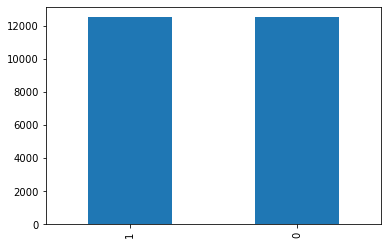

In [10]:
df['category'].value_counts().plot.bar()

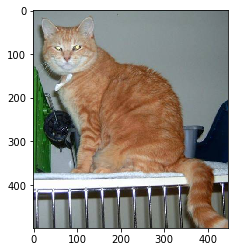

In [11]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka danych

In [12]:
 '''
Podział danych z całego df na X i y:

X - wszystko oprócz category
y - category
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [13]:
df.head()

,filename,category
0,../data/DogsCats/cats/cat.493.jpg,1
1,../data/DogsCats/dogs/dog.9112.jpg,0
2,../data/DogsCats/cats/cat.745.jpg,1
3,../data/DogsCats/dogs/dog.11022.jpg,0
4,../data/DogsCats/dogs/dog.11363.jpg,0


In [14]:
X.head()

,filename
0,../data/DogsCats/cats/cat.493.jpg
1,../data/DogsCats/dogs/dog.9112.jpg
2,../data/DogsCats/cats/cat.745.jpg
3,../data/DogsCats/dogs/dog.11022.jpg
4,../data/DogsCats/dogs/dog.11363.jpg


In [15]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: category, dtype: int64

In [16]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych
test  - 20% danych
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

# Reset indeksów
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

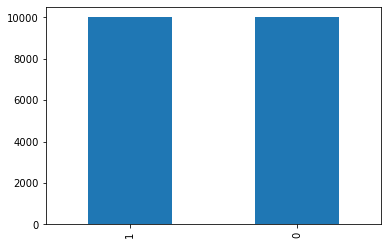

In [17]:
train['category'].value_counts().plot.bar()

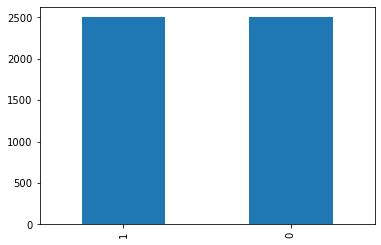

In [18]:
test['category'].value_counts().plot.bar()

In [19]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (25000, 2)
	 train: (20000, 2)
	 test: (5000, 2)


In [20]:
# Upewnienie się że dane w train[filename] i test[filename] są stringiem - lepsze dla generatorów

train['filename'] = train['filename'].astype(str) 
test['filename'] = test['filename'].astype(str)

# Upewnienie się że dane w train[category] i test[category] są stringiem - lepsze dla generatorów

train['category'] = train['category'].astype(str) 
test['category'] = test['category'].astype(str)

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t train: {train.shape}')
print(f'\t test: {test.shape}')

Kształt danych:
	 df: (25000, 2)
	 train: (20000, 2)
	 test: (5000, 2)


# Funkcję liczące statystyki

In [22]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [23]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [24]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [25]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

In [26]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 15
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [27]:
from keras import optimizers

batch_size = 16
activation = 'relu'
loss_type = 'binary_crossentropy'
optimizer = optimizers.RMSprop(lr=2e-5)
dropout = 0.25
epochs = 50

# Generatory

In [28]:
'''
Generator dla danych trenningowych
'''

from keras.applications.vgg16 import preprocess_input

data_gen = ImageDataGenerator(
#     preprocessing_function=preprocess_input
    rescale=1./255,
#     zoom_range=[0, 0.2],
    horizontal_flip=True,
    vertical_flip=True
)

data_test_gen = ImageDataGenerator(
    rescale=1./255
)

train_generator = data_gen.flow_from_dataframe(
    dataframe = train,
    x_col = 'filename',
    y_col = 'category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [29]:
'''
Generator dla danych testowych
 * reskalowanie
'''

test_generator = data_test_gen.flow_from_dataframe( 
    dataframe = test,
    x_col = 'filename',
    y_col = 'category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [30]:
example_df = train.sample(n=1).reset_index(drop=True)

example_generator = data_gen.flow_from_dataframe(
    dataframe = example_df,
    x_col = 'filename',
    y_col = 'category',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


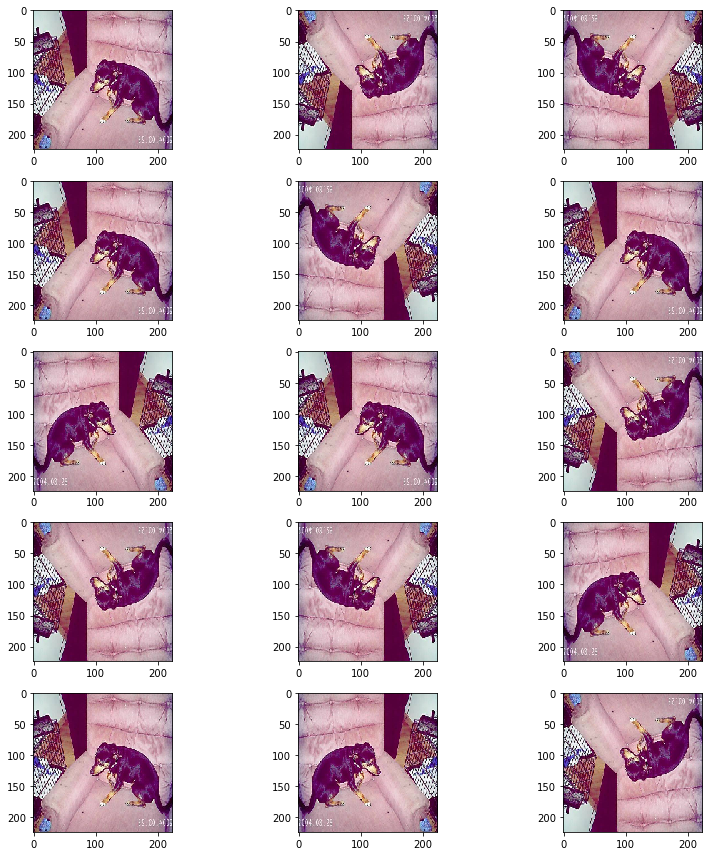

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Model Fine-Tuning

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet import ResNet50
from keras.applications import VGG16

pre_trained_model_fn = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

for layer in pre_trained_model_fn.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model_fn.layers[15:]:
    layer.trainable = True

model_fn = Sequential()

model_fn.add(pre_trained_model_fn)
model_fn.add(Flatten())
model_fn.add(Dense(256, activation=activation))
model_fn.add(Dropout(dropout))
model_fn.add(BatchNormalization())
model_fn.add(Dense(1, activation='sigmoid'))

model_fn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,138,753
Trainable params: 13,502,977
Non-trainable params: 7,635,776
__________________________________

# Fit

In [33]:
model_fn.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history_fn = model_fn.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test.shape[0]//batch_size,
    steps_per_epoch = train.shape[0]//batch_size,
    callbacks = [cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model_fn.load_weights('best.h5')

# Zapis
model_fn.save('the_best_fn_P.h5')

Epoch 1/50
1250/1250 [==============================] - 283s 226ms/step - loss: 0.2910 - accuracy: 0.8756 - get_f1: 0.8727 - val_loss: 0.1752 - val_accuracy: 0.9207 - val_get_f1: 0.9220

Epoch 00001: val_loss improved from inf to 0.17524, saving model to best.h5
Epoch 2/50
1250/1250 [==============================] - 127s 101ms/step - loss: 0.1906 - accuracy: 0.9244 - get_f1: 0.9212 - val_loss: 0.0362 - val_accuracy: 0.9520 - val_get_f1: 0.9495

Epoch 00002: val_loss improved from 0.17524 to 0.03617, saving model to best.h5
Epoch 3/50
1250/1250 [==============================] - 126s 101ms/step - loss: 0.1598 - accuracy: 0.9382 - get_f1: 0.9344 - val_loss: 0.1554 - val_accuracy: 0.9390 - val_get_f1: 0.9308

Epoch 00003: val_loss did not improve from 0.03617
Epoch 4/50
1250/1250 [==============================] - 128s 103ms/step - loss: 0.1323 - accuracy: 0.9502 - get_f1: 0.9468 - val_loss: 0.0125 - val_accuracy: 0.9151 - val_get_f1: 0.9015

Epoch 00004: val_loss improved from 0.03617 t

1250/1250 [==============================] - 124s 99ms/step - loss: 0.0215 - accuracy: 0.9934 - get_f1: 0.9921 - val_loss: 0.1235 - val_accuracy: 0.9675 - val_get_f1: 0.9635

Epoch 00033: val_loss did not improve from 0.00037
Epoch 34/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.0209 - accuracy: 0.9934 - get_f1: 0.9925 - val_loss: 0.0084 - val_accuracy: 0.9667 - val_get_f1: 0.9634

Epoch 00034: val_loss did not improve from 0.00037
Epoch 35/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.0210 - accuracy: 0.9938 - get_f1: 0.9929 - val_loss: 0.5483 - val_accuracy: 0.9699 - val_get_f1: 0.9674

Epoch 00035: val_loss did not improve from 0.00037
Epoch 36/50
1250/1250 [==============================] - 124s 99ms/step - loss: 0.0228 - accuracy: 0.9934 - get_f1: 0.9920 - val_loss: 8.7394e-04 - val_accuracy: 0.9651 - val_get_f1: 0.9625

Epoch 00036: val_loss did not improve from 0.00037

Epoch 00036: ReduceLROnPlateau reducing learning rate t

# Statystyki

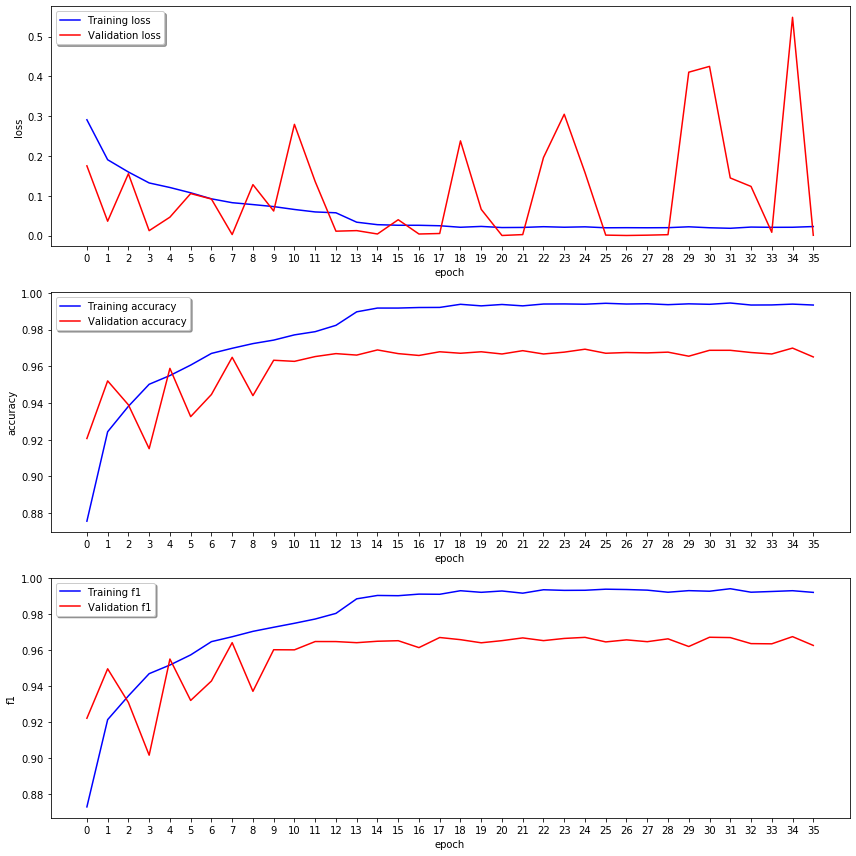

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history_fn.history['loss'], color='b', label="Training loss")
ax1.plot(history_fn.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history_fn.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history_fn.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_fn.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history_fn.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history_fn.history['get_f1'], color='b', label="Training f1")
ax3.plot(history_fn.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history_fn.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

In [35]:
stats_df = pd.DataFrame({
    'filename': test['filename'],
    'category': test['category'],
    'predict_fn': None
})

# Mieszamy!
stats_df = stats_df.sample(frac=1).reset_index(drop=True)

stats_df.head()

,filename,category,predict_fn
0,../data/DogsCats/dogs/dog.12440.jpg,0,None
1,../data/DogsCats/dogs/dog.5428.jpg,0,None
2,../data/DogsCats/cats/cat.545.jpg,1,None
3,../data/DogsCats/dogs/dog.1685.jpg,0,None
4,../data/DogsCats/dogs/dog.7785.jpg,0,None


In [36]:
validate_generator = data_gen.flow_from_dataframe( 
    dataframe = stats_df,
    x_col = 'filename',
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5000 validated image filenames.


In [37]:
predict_fn = model_fn.predict_generator(validate_generator, verbose=True)

313/313 [==============================] - 20s 65ms/step


In [38]:
# Zamiana z one hot encodera na jedno wyjście
stats_df['predict_fn'] = list(map(lambda x: 1 if x > 0.5 else 0,predict_fn))

In [39]:
stats_df.head()

,filename,category,predict_fn
0,../data/DogsCats/dogs/dog.12440.jpg,0,0
1,../data/DogsCats/dogs/dog.5428.jpg,0,0
2,../data/DogsCats/cats/cat.545.jpg,1,1
3,../data/DogsCats/dogs/dog.1685.jpg,0,0
4,../data/DogsCats/dogs/dog.7785.jpg,0,0


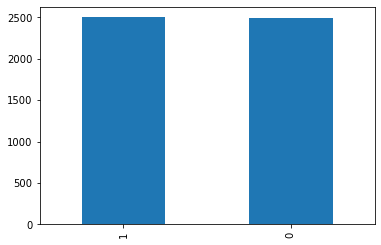

In [40]:
stats_df['predict_fn'].value_counts().plot.bar()

In [41]:
y_true_fn = stats_df['category'].to_numpy().astype(int)
y_pred_fn = stats_df['predict_fn'].to_numpy().astype(int)

In [42]:
cm_fn = confusion_matrix(y_true_fn, y_pred_fn)

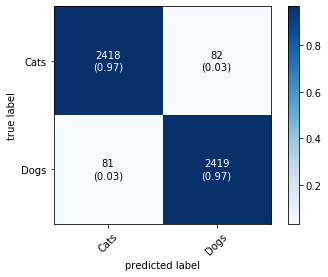

In [43]:
plot_cm(cm_fn, ['Cats', 'Dogs'])

In [44]:
print(cm_fn)

[[2418   82]
 [  81 2419]]


In [45]:
loss, accuracy, get_f1  = model_fn.evaluate_generator(test_generator, verbose=True)

313/313 [==============================] - 20s 65ms/step


In [46]:
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')

Test loss: 0.00449
Test accuracy: 0.967
Test F1: 0.965


In [47]:
accuracy, precision, recall, fscore = countStats(y_true_fn, y_pred_fn)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.9674
Precision: 0.967400074784012
Recall: 0.9674
F-score: 0.967399998696
